In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.base import clone
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from scipy.optimize import minimize
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import optuna



In [13]:
# Constants
SEED = 42

In [24]:
# Loading the datasets
train_file_path = "train.csv"
train_df = pd.read_csv(train_file_path)
test_file_path = "test.csv"
test_df = pd.read_csv(test_file_path)
df = train_df

# DATA EXPLORATION

In [25]:
# Basic Info about Dataset
print("\n🔹 Dataset Info:")
print(df.info())


🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898

In [26]:
# Checking for Missing Values
print("\n🔍 Missing Values Count:")
print(df.isnull().sum())


🔍 Missing Values Count:
id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 82, dtype: int64


In [27]:
# Summary Statistics
print("\n📊 Summary Statistics (Numerical Features):")
print(df.describe())


📊 Summary Statistics (Numerical Features):
       Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.433586         0.372727        65.454771     19.331929   
std           3.574648         0.483591        22.341862      5.113934   
min           5.000000         0.000000        25.000000      0.000000   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          22.000000         1.000000       999.000000     59.132048   

       Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
count      3027.000000      3076.000000                    898.000000   
mean         55.946713        89.038615                     27.278508   
std           7.473764        44.569040                      5.567287 

In [28]:
# Identify Categorical & Numerical Columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"\n📝 Categorical Columns: {list(categorical_cols)}")
print(f"\n🔢 Numerical Columns: {list(numerical_cols)}")


📝 Categorical Columns: ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']

🔢 Numerical Columns: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA

In [29]:
len(numerical_cols)

70

In [30]:
## Correlation
covariance_matrix = df.select_dtypes(include=['float64','int64']).corr()
display(covariance_matrix)
covariance_matrix.to_csv("covariance_matrix.csv")

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
Basic_Demos-Age,1.000000,0.064004,-0.009994,0.492112,0.880274,0.748149,0.609601,0.107960,-0.218527,0.263875,...,0.085805,0.286888,0.159826,0.303259,0.286309,0.409559,0.037317,0.037115,0.441822,0.365990
Basic_Demos-Sex,0.064004,1.000000,0.075470,0.025793,-0.014454,0.003245,-0.020013,0.002076,0.026675,-0.025256,...,-0.097824,-0.102390,-0.110080,-0.104911,-0.067966,-0.093648,-0.020122,-0.018508,-0.000579,-0.100148
CGAS-CGAS_Score,-0.009994,0.075470,1.000000,-0.094074,-0.023185,-0.076399,-0.076116,-0.005292,-0.010108,-0.021392,...,-0.065687,-0.047770,-0.067922,-0.065210,-0.067920,-0.070542,-0.145369,-0.148457,-0.021596,-0.085261
Physical-BMI,0.492112,0.025793,-0.094074,1.000000,0.487097,0.865662,0.892149,0.141795,-0.036955,0.312045,...,0.071017,0.152122,0.100032,0.181208,0.161034,0.240858,0.087655,0.086185,0.296709,0.221125
Physical-Height,0.880274,-0.014454,-0.023185,0.487097,1.000000,0.833844,0.688033,0.115724,-0.217080,0.299157,...,0.112369,0.300590,0.184409,0.307084,0.292542,0.420765,0.036687,0.036478,0.399367,0.373530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,0.409559,-0.093648,-0.070542,0.240858,0.420765,0.353048,0.327013,0.069321,-0.037594,0.147081,...,0.769422,0.823708,0.802030,0.737243,0.754277,1.000000,0.234432,0.237718,0.374124,0.899681
SDS-SDS_Total_Raw,0.037317,-0.020122,-0.145369,0.087655,0.036687,0.075098,0.089831,0.006702,0.049194,0.036562,...,0.250015,0.177323,0.239387,0.171186,0.209167,0.234432,1.000000,0.996134,0.083501,0.229692
SDS-SDS_Total_T,0.037115,-0.018508,-0.148457,0.086185,0.036478,0.073482,0.091152,0.008502,0.047932,0.038317,...,0.252715,0.180220,0.241844,0.173366,0.209338,0.237718,0.996134,1.000000,0.086050,0.232982
PreInt_EduHx-computerinternet_hoursday,0.441822,-0.000579,-0.021596,0.296709,0.399367,0.375851,0.371418,0.074258,-0.073453,0.137728,...,0.180736,0.299658,0.223794,0.290488,0.245310,0.374124,0.083501,0.086050,1.000000,0.336526


In [31]:
numeric_df = train_df.select_dtypes(include='number')

min_max_df = pd.DataFrame({
    'Min': numeric_df.min(),
    'Max': numeric_df.max()
}).sort_values(by='Min', ascending=True)  # or sort by 'Max' if preferred

print(min_max_df)

                        Min          Max
BIA-BIA_Fat     -8745.08000     153.8200
BIA-BIA_FMI      -194.16300      28.2515
BIA-BIA_BMC        -7.78961    4115.3600
sii                 0.00000       3.0000
FGC-FGC_TL_Zone     0.00000       1.0000
...                     ...          ...
BIA-BIA_FFM        28.90040    8799.0800
Physical-Height    33.00000      78.5000
SDS-SDS_Total_T    38.00000     100.0000
BIA-BIA_BMR       813.39700   83152.2000
BIA-BIA_DEE      1073.45000  124728.0000

[70 rows x 2 columns]


# BASIC DATA CLEANING

In [32]:
def clean_data(df):
    
    season_colums = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_colums, axis=1) # Removes columns with 'Season' in the name
    
    df = df.drop(columns=['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'])
    
    df["BIA-BIA_Fat"] = df["BIA-BIA_Fat"].abs() # Replaces negative values with positive values

    df["BIA-BIA_FMI"] = df["BIA-BIA_FMI"].abs() # Replaces negative values with positive values

    df.loc[df["BIA-BIA_Fat"] > 65, "BIA-BIA_Fat"] = np.nan # Replaces values greater than 65 with NaN - more than 65% body fat is not possible

    df.loc[df["BIA-BIA_Fat"] < 5, "BIA-BIA_Fat"] = np.nan # Replaces values less than 5 with NaN - less 5% body fat is not possible

    df.loc[df["BIA-BIA_FMI"] > 40, "BIA-BIA_FMI"] = np.nan # Replaces values greater than 40 with NaN

    df[['FGC-FGC_GSND', 'FGC-FGC_GSD']] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].clip(lower=0, upper=100) # Replaces values less than 0 with 0 and values greater than 100 with 100

    df.loc[df["BIA-BIA_BMR"] > 4000, "BIA-BIA_BMR"] = np.nan # Replaces values greater than 4000 with NaN

    df.loc[df["BIA-BIA_DEE"] > 8000, "BIA-BIA_DEE"] = np.nan # Replaces values greater than 8000 with NaN

    df["BIA-BIA_BMC"] = df["BIA-BIA_BMC"].abs() # Replaces negative values with positive values

    df[['BIA-BIA_BMC']] = df[['BIA-BIA_BMC']].clip(lower=0, upper=10) # Replaces values less than 0 with 0 and values greater than 10 with 10

    df.loc[df["BIA-BIA_BMC"] == 0, "BIA-BIA_BMC"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["BIA-BIA_FFM"] > 400, "BIA-BIA_FFM"] = np.nan # Replaces values greater than 400 with NaN

    df.loc[df["BIA-BIA_ECW"] > 100, "BIA-BIA_ECW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_ICW"] > 100, "BIA-BIA_ICW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LDM"] > 100, "BIA-BIA_LDM"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LST"] > 300, "BIA-BIA_LST"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_TBW"] > 300, "BIA-BIA_TBW"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_SMM"] > 300, "BIA-BIA_SMM"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["Physical-Height"] == 0, "Physical-Height"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["Physical-Weight"] == 0, "Physical-Weight"] = np.nan # Replaces values equal to 0 with NaN
    
    df.loc[df['CGAS-CGAS_Score'] == 999, 'CGAS-CGAS_Score'] = np.nan #Replace the single outlier CGAS Score with NAN

    df['PAQ_Total'] = df['PAQ_C-PAQ_C_Total'].fillna(df['PAQ_A-PAQ_A_Total']) # Fills missing values in PAQ_Total with values from PAQ_A-PAQ_A_Total

    df = df.drop('PAQ_C-PAQ_C_Total', axis=1) 
    df = df.drop('PAQ_A-PAQ_A_Total', axis=1)
    
    # Removes columns with 'Zone' in the name because they are not properly assigned - there is a lot of noise in the data.
    df = df.drop(columns=['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone'])
    
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df) 

In [33]:
# Quick function to display the statistics of a column
def get_statistic(df_col):
    print(df_col.describe())

def assign_groups(age):
    thresholds = [5, 10, 15, 18, 22] # Define the age thresholds for grouping.
    for i, j in enumerate(thresholds):
        if age <= j:
            return i
    return np.nan

def group_statistics(df, column):
    mean_value = df.groupby('age_group')[column].mean() # Calculate the mean value of the column for each age group.
    print(mean_value)

train_df['age_group'] = train_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.
test_df['age_group'] = test_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.



# DATA IMPUTATION

In [34]:
pd.reset_option('display.max_rows')

In [35]:
train_df

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,PAQ_Total,age_group
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,4.0,2.0,4.0,55.0,NaN,NaN,3.0,2.0,NaN,0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,0.0,0.0,0.0,0.0,46.0,64.0,0.0,0.0,2.340,1
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,2.0,1.0,1.0,28.0,38.0,54.0,2.0,0.0,2.170,1
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,3.0,4.0,1.0,44.0,31.0,45.0,0.0,1.0,2.451,1
4,0016bb22,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,13,0,60.0,16.362460,59.5,82.4,NaN,71.0,70.0,...,1.0,1.0,0.0,32.0,35.0,50.0,1.0,1.0,3.260,2
3956,ffa9794a,10,0,NaN,18.764678,53.5,76.4,27.0,60.0,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.340,1
3957,ffcd4dbd,11,0,68.0,21.441500,60.0,109.8,NaN,79.0,99.0,...,1.0,0.0,1.0,31.0,56.0,77.0,0.0,1.0,2.729,2
3958,ffed1dd5,13,0,70.0,12.235895,70.7,87.0,NaN,59.0,61.0,...,1.0,1.0,1.0,19.0,33.0,47.0,1.0,0.0,3.300,2


In [36]:
pd.set_option('display.max_rows', None)

missing_cols = train_df.isna().sum()
missing_cols = missing_cols[missing_cols > 0]
print(missing_cols)

CGAS-CGAS_Score                           1540
Physical-BMI                               938
Physical-Height                            933
Physical-Weight                            945
Physical-Waist_Circumference              3062
Physical-Diastolic_BP                     1006
Physical-HeartRate                         993
Physical-Systolic_BP                      1006
FGC-FGC_CU                                1638
FGC-FGC_GSND                              2886
FGC-FGC_GSD                               2886
FGC-FGC_PU                                1650
FGC-FGC_SRL                               1655
FGC-FGC_SRR                               1653
FGC-FGC_TL                                1636
BIA-BIA_Activity_Level_num                1969
BIA-BIA_BMC                               1969
BIA-BIA_BMI                               1969
BIA-BIA_BMR                               1971
BIA-BIA_DEE                               1971
BIA-BIA_ECW                               1974
BIA-BIA_FFM  

In [37]:
corr = pd.DataFrame(train_df.select_dtypes(include='number').corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
PCIAT-PCIAT_05,0.830993
PCIAT-PCIAT_15,0.823996
PCIAT-PCIAT_17,0.823708
PCIAT-PCIAT_03,0.823336
PCIAT-PCIAT_18,0.802030
PCIAT-PCIAT_02,0.788802
PCIAT-PCIAT_13,0.771990
PCIAT-PCIAT_08,0.770499


### Height and Weight using KNN Imputation

In [38]:
# 1. Getting all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Getting the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Defining our target columns
target_cols = ['Physical-Height', 'Physical-Weight']

# 4. Finding non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, getting sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with Physical-Height:

Found 3 valid correlations
Basic_Demos-Age    0.880274
age_group          0.792613
Basic_Demos-Sex   -0.014454
Name: Physical-Height, dtype: float64

Top correlated non-missing columns with Physical-Weight:

Found 3 valid correlations
Basic_Demos-Age    0.781934
age_group          0.725087
Basic_Demos-Sex    0.003113
Name: Physical-Weight, dtype: float64


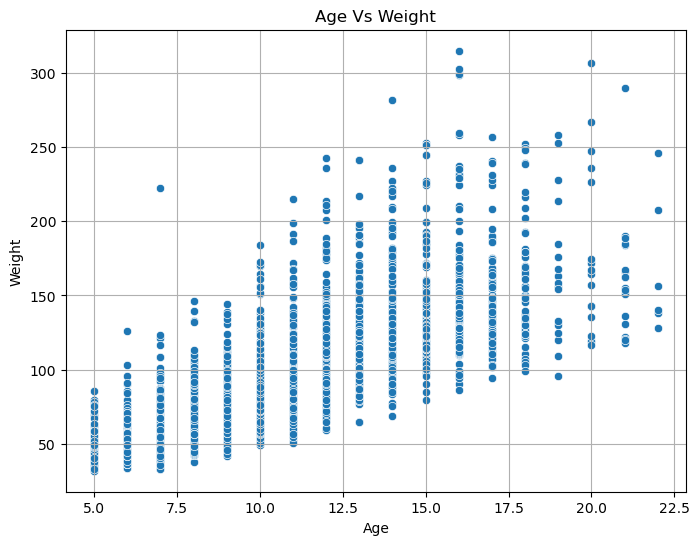

In [39]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Weight'
)
plt.title('Age Vs Weight')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

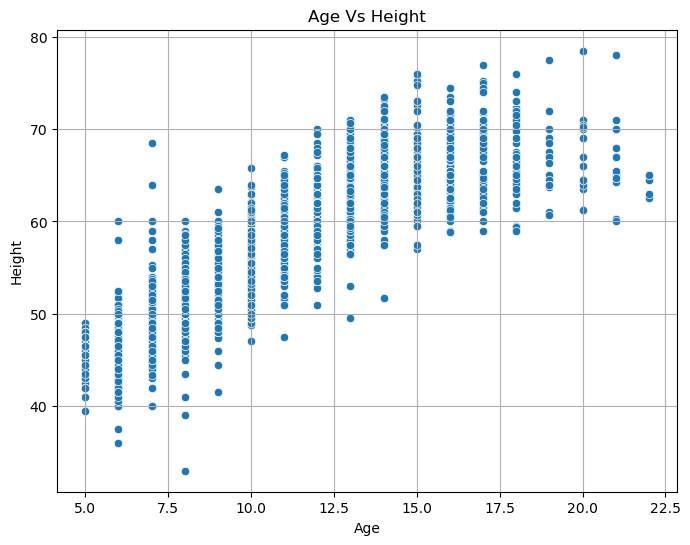

In [40]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Height'
)
plt.title('Age Vs Height')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True)
plt.show()

In [41]:
train_df['Physical-Height'].min()

33.0

In [42]:
columns = ['Physical-Height', 'Physical-Weight', 'Basic_Demos-Age', 'Basic_Demos-Sex']

# Selecting only these columns for imputation
train_subset = train_df[columns]
test_subset = test_df[columns]

# 2. Creating and fittinf the imputer ONLY on training data
imputer = KNNImputer(n_neighbors=3)
imputer.fit(train_subset)   # <-- fit only on train!

# 3. Transforming both train and test
train_imputed = pd.DataFrame(imputer.transform(train_subset), columns=columns)
test_imputed = pd.DataFrame(imputer.transform(test_subset), columns=columns)

# 4. Replacing the imputed columns in original dataframes
column_replace = ['Physical-Height', 'Physical-Weight']
for col in column_replace:
    train_df[col] = train_imputed[col]
    test_df[col] = test_imputed[col]

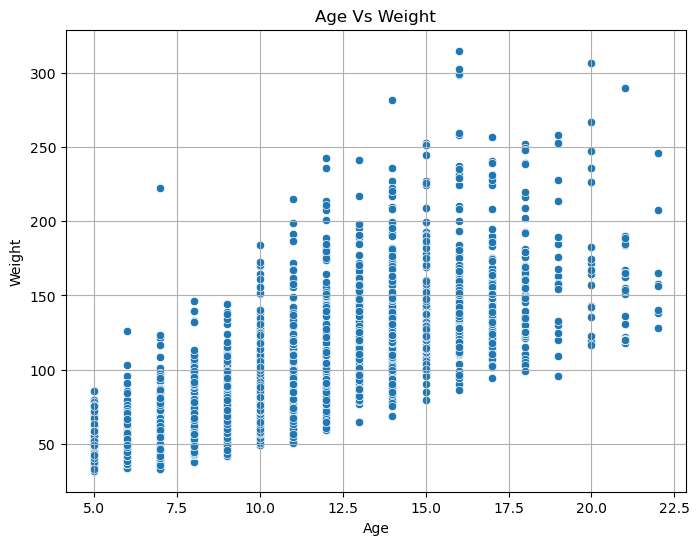

In [43]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Weight'
)
plt.title('Age Vs Weight')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

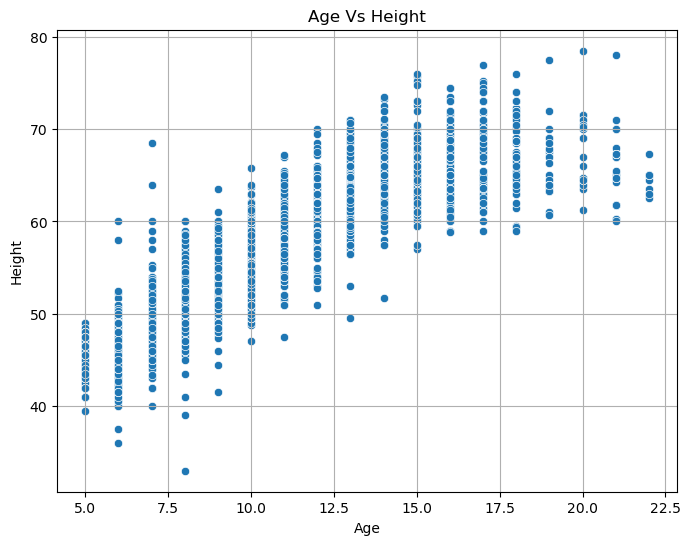

In [44]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Basic_Demos-Age',
    y='Physical-Height'
)
plt.title('Age Vs Height')
plt.xlabel('Age')
plt.ylabel('Height')
plt.grid(True)
plt.show()

### Imputing BMI using Height and Weight

In [45]:
train_df['Physical-Weight'] = train_df['Physical-Weight'] * 0.453592
train_df['Physical-Height'] = train_df['Physical-Height'] * 0.0254

test_df['Physical-Weight'] = test_df['Physical-Weight'] * 0.453592
test_df['Physical-Height'] = test_df['Physical-Height'] * 0.0254

In [46]:
def recompute_bmi(df):
    mask = df['Physical-Weight'].notna() & df['Physical-Height'].notna()
    df['Physical-BMI'] = np.nan
    df.loc[mask, 'Physical-BMI'] = df.loc[mask, 'Physical-Weight'] / (df.loc[mask, 'Physical-Height'] ** 2)
    return df

# Apply to both
train_df = recompute_bmi(train_df)
test_df = recompute_bmi(test_df)

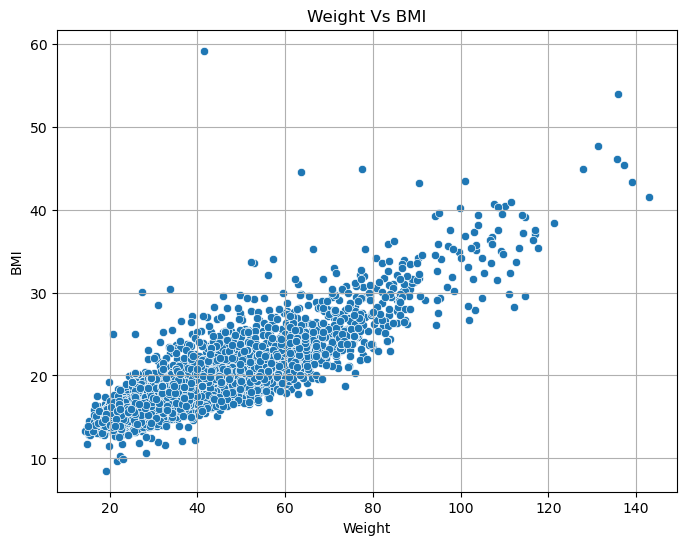

In [47]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Physical-Weight',
    y='Physical-BMI'
)
plt.title('Weight Vs BMI')
plt.xlabel('Weight')
plt.ylabel('BMI')
plt.grid(True)
plt.show()

In [48]:
train_df = train_df.drop(columns=['BIA-BIA_BMI'])

#### Impute waist circumference using linear regression

In [49]:
# 1. Getting all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Gettinf the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Defining our target columns
target_cols = ['Physical-Waist_Circumference']

# 4. Finding non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, gettinf sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with Physical-Waist_Circumference:

Found 6 valid correlations
Physical-Weight    0.915839
Physical-BMI       0.891014
Physical-Height    0.688211
Basic_Demos-Age    0.609601
age_group          0.562547
Basic_Demos-Sex   -0.020013
Name: Physical-Waist_Circumference, dtype: float64


In [50]:
columns = ['Physical-Weight', 'Physical-BMI', 'Physical-Waist_Circumference']
columns_to_impute = ['Physical-Waist_Circumference']

def iterative_impute(train_df, test_df, columns):
    subset_train = train_df[columns]
    subset_test = test_df[columns]
    imputer = IterativeImputer(estimator=BayesianRidge())
    imputer.fit(subset_train)
    train_imputed = pd.DataFrame(imputer.transform(subset_train), columns=columns)
    test_imputed = pd.DataFrame(imputer.transform(subset_test), columns=columns)
    for col in columns_to_impute:
        train_df[col] = train_imputed[col]
        test_df[col] = test_imputed[col]
    return train_df, test_df

# Usage:
train_df, test_df = iterative_impute(train_df, test_df, columns)

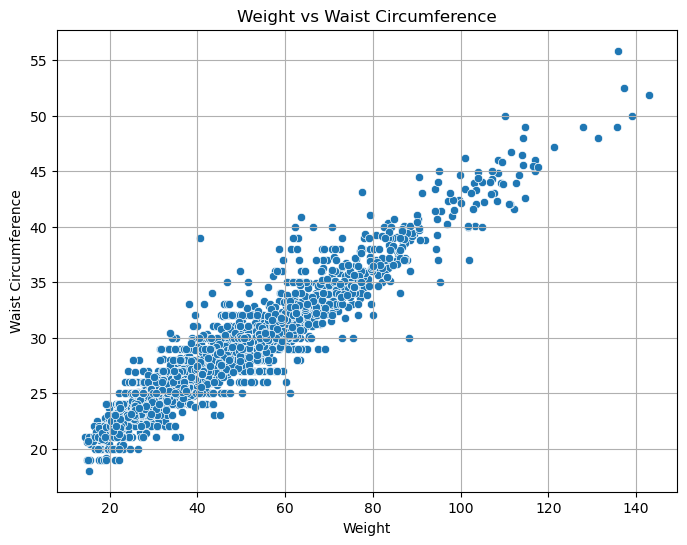

In [51]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='Physical-Weight',
    y='Physical-Waist_Circumference'
)
plt.title('Weight vs Waist Circumference')
plt.xlabel('Weight')
plt.ylabel('Waist Circumference')
plt.grid(True)
plt.show()

In [52]:
train_df['Physical-Waist_Circumference'].isna().sum()

0

#### Imputing SDS-Total-Raw using KNN Imputation

In [53]:
equal_mask = train_df['SDS-SDS_Total_T'] == train_df['SDS-SDS_Total_Raw']
print(f"{equal_mask.sum()} records have equal values.")

0 records have equal values.


In [54]:
train_df['SDS_Diff'] = train_df['SDS-SDS_Total_T'] - train_df['SDS-SDS_Total_Raw']
train_df['SDS_Diff']

0        NaN
1       18.0
2       16.0
3       14.0
4        NaN
5       16.0
6       13.0
7        NaN
8        NaN
9        NaN
10       NaN
11      17.0
12      14.0
13       NaN
14       NaN
15      15.0
16      16.0
17       NaN
18      16.0
19       NaN
20      13.0
21       NaN
22      20.0
23      19.0
24      15.0
25      13.0
26       NaN
27      16.0
28      15.0
29       NaN
30       NaN
31      13.0
32      24.0
33       NaN
34       NaN
35       NaN
36      16.0
37       NaN
38      25.0
39       NaN
40      19.0
41      19.0
42       NaN
43       NaN
44      14.0
45      15.0
46      17.0
47       NaN
48      14.0
49      16.0
50      17.0
51      18.0
52      15.0
53      15.0
54      13.0
55      16.0
56      20.0
57      19.0
58      14.0
59       NaN
60      15.0
61      17.0
62      19.0
63      15.0
64      19.0
65       NaN
66      19.0
67       NaN
68       NaN
69       NaN
70      15.0
71       NaN
72      14.0
73       NaN
74       NaN
75      14.0
76       NaN

In [55]:
train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,PAQ_Total,age_group,SDS_Diff
count,3960.000000,3960.000000,2420.000000,3960.000000,3960.000000,3960.000000,3960.000000,2954.000000,2967.000000,2954.000000,...,2730.000000,2733.000000,2736.000000,2609.000000,2606.000000,3301.000000,2736.000000,2195.000000,3960.000000,2606.000000
mean,10.433586,0.372727,65.069008,19.570778,1.424915,41.685607,27.155470,69.648951,81.597236,116.983074,...,1.158974,0.943652,27.896199,41.088923,57.763622,1.060588,0.580409,2.500820,1.522475,16.685342
std,3.574648,0.483591,11.787310,4.580872,0.187490,18.641519,4.683109,13.611226,13.665196,17.061225,...,1.343661,1.185460,20.338853,10.427433,13.196091,1.094875,0.771122,0.816259,0.781512,2.958185
min,5.000000,0.000000,25.000000,8.523273,0.838200,14.424226,18.000000,0.000000,27.000000,0.000000,...,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000,0.580000,0.000000,4.000000
25%,8.000000,0.000000,59.000000,16.425001,1.295400,28.031986,23.983409,61.000000,72.000000,107.000000,...,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000,1.880000,1.000000,14.000000
50%,10.000000,0.000000,65.000000,18.679585,1.404620,36.196642,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000,2.460000,1.000000,16.000000
75%,13.000000,1.000000,75.000000,21.586521,1.574800,53.523856,29.623670,76.000000,90.500000,125.000000,...,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000,3.090000,2.000000,18.000000
max,22.000000,1.000000,95.000000,59.137852,1.993900,142.881480,55.847379,179.000000,138.000000,203.000000,...,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000,4.790000,4.000000,26.000000


In [56]:
train_df = train_df.drop(columns=['SDS_Diff'])

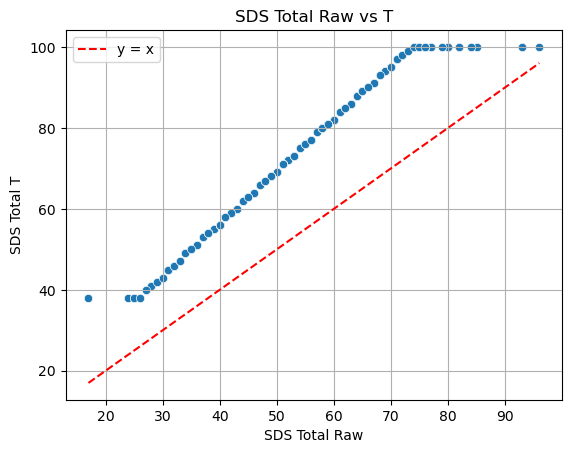

In [57]:
sns.scatterplot(
    x='SDS-SDS_Total_Raw',
    y='SDS-SDS_Total_T',
    data=train_df
)
plt.plot([train_df['SDS-SDS_Total_Raw'].min(), train_df['SDS-SDS_Total_Raw'].max()],
         [train_df['SDS-SDS_Total_Raw'].min(), train_df['SDS-SDS_Total_Raw'].max()],
         color='red', linestyle='--', label='y = x')
plt.legend()
plt.title('SDS Total Raw vs T')
plt.xlabel('SDS Total Raw')
plt.ylabel('SDS Total T')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


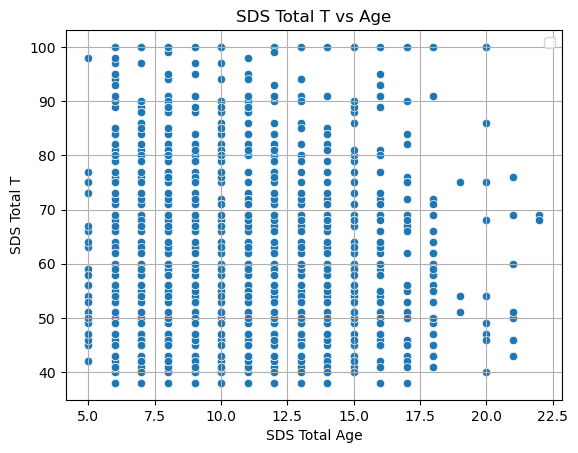

In [58]:
sns.scatterplot(
    x='Basic_Demos-Age',
    y='SDS-SDS_Total_T',
    data=train_df
)

plt.legend()
plt.title('SDS Total T vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total T')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


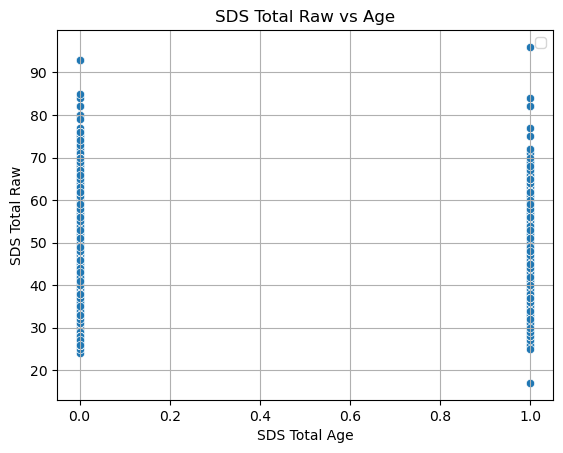

In [59]:
sns.scatterplot(
    x='Basic_Demos-Sex',
    y='SDS-SDS_Total_Raw',
    data=train_df
)

plt.legend()
plt.title('SDS Total Raw vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total Raw')
plt.grid(True)
plt.show()

In [60]:
train_df = train_df.drop(columns=['SDS-SDS_Total_T'])

In [61]:
# 1. Getting all columns with missing values
missing_cols = train_df.columns[train_df.isna().any()]

# 2. Getting the correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# 3. Defining your target columns
target_cols = ['SDS-SDS_Total_Raw']

# 4. Finding non-missing columns
non_missing_cols = [col for col in train_df.columns if col not in missing_cols]

# 5. For each target, getting sorted correlations with non-missing columns
for target in target_cols:
    print(f"\nTop correlated non-missing columns with {target}:\n")
    if target not in corr_matrix:
        print("No correlation available (likely too many NaNs).")
        continue
    correlations = corr_matrix[target].dropna()
    correlations = correlations[correlations.index.isin(non_missing_cols) & (correlations.index != target)]
    print(f"Found {len(correlations)} valid correlations")
    print(correlations.sort_values(ascending=False).head(10))


Top correlated non-missing columns with SDS-SDS_Total_Raw:

Found 7 valid correlations
Physical-BMI                    0.097060
Physical-Waist_Circumference    0.094212
Physical-Weight                 0.088988
Physical-Height                 0.045744
age_group                       0.041960
Basic_Demos-Age                 0.037317
Basic_Demos-Sex                -0.020122
Name: SDS-SDS_Total_Raw, dtype: float64


In [62]:
# Columns we want to impute
columns = ['SDS-SDS_Total_Raw', 'Basic_Demos-Age', 'Basic_Demos-Sex']
columns_to_impute = ['SDS-SDS_Total_Raw']
# 1. Selecting the subset from train and test
train_subset = train_df[columns]
test_subset = test_df[columns]

# 2. Creating and fitting the imputer ONLY on training data
imputer = KNNImputer(n_neighbors=3)
imputer.fit(train_subset)   # <-- fitting only on train!

# 3. Transforming both train and test
train_imputed = pd.DataFrame(imputer.transform(train_subset), columns=columns)
test_imputed = pd.DataFrame(imputer.transform(test_subset), columns=columns)

# 4. Replacing the imputed columns in original dataframes
for col in columns_to_impute:
    train_df[col] = train_imputed[col]
    test_df[col] = test_imputed[col]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


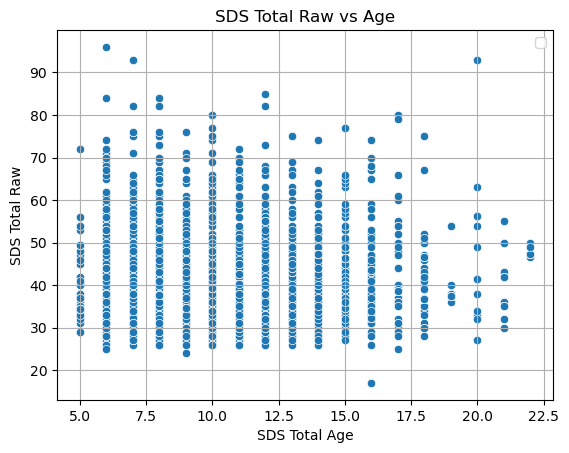

In [63]:
sns.scatterplot(
    x='Basic_Demos-Age',
    y='SDS-SDS_Total_Raw',
    data=train_df
)

plt.legend()
plt.title('SDS Total Raw vs Age')
plt.xlabel('SDS Total Age')
plt.ylabel('SDS Total Raw')
plt.grid(True)
plt.show()

#### Imputing Internet Hours

In [64]:
#quick function for summary data for post and pre imputation
def summarize_data(df, selected_columns=None):
    # Convert single column name to list
    if isinstance(selected_columns, str):
        selected_columns = [selected_columns]
    
    # Use all columns if none specified
    if selected_columns is None:
        selected_columns = df.columns.tolist()
    
    result_tables = []
    
    for column in selected_columns:
        # Get the data for the current column
        col_data = df[column]
        
        # Handle categorical or text data
        if col_data.dtype in ['object', 'category']:
            # Calculate frequencies and percentages
            freq_table = pd.DataFrame()
            values = col_data.value_counts(dropna=False)
            percentages = col_data.value_counts(dropna=False, normalize=True) * 100
            
            # Combine counts and percentages
            freq_table['count (%)'] = [
                f"{count} ({percentage:.2f}%)" 
                for count, percentage in zip(values, percentages)
            ]
            
            result_tables.append(freq_table)
        
        # Handle numerical data
        else:
            # Get descriptive statistics
            num_stats = pd.DataFrame()
            
            # Add basic statistics as a row
            descriptives = col_data.describe().to_dict()
            num_stats = pd.DataFrame(descriptives, index=[0])
            
            # Add missing values count
            num_stats['missing'] = col_data.isna().sum()
            
            # Set index name
            num_stats.index = [column]
            
            result_tables.append(num_stats)
    
    # Combine all results
    combined_stats = pd.concat(result_tables)
    
    return combined_stats

In [65]:
summarize_data(train_df, ['PreInt_EduHx-computerinternet_hoursday'])

,count,mean,std,min,25%,50%,75%,max,missing
PreInt_EduHx-computerinternet_hoursday,3301.0,1.060588,1.094875,0.0,0.0,1.0,2.0,3.0,659


In [66]:
internet_data_age = train_df[train_df['PreInt_EduHx-computerinternet_hoursday'].notna()]
age_range = internet_data_age['Basic_Demos-Age']
print(
    f"Range of Age for those who have internet usage data calculated/already exisiting within our initial data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Range of Age for those who have internet usage data calculated/already exisiting within our initial data: 5 - 22 years


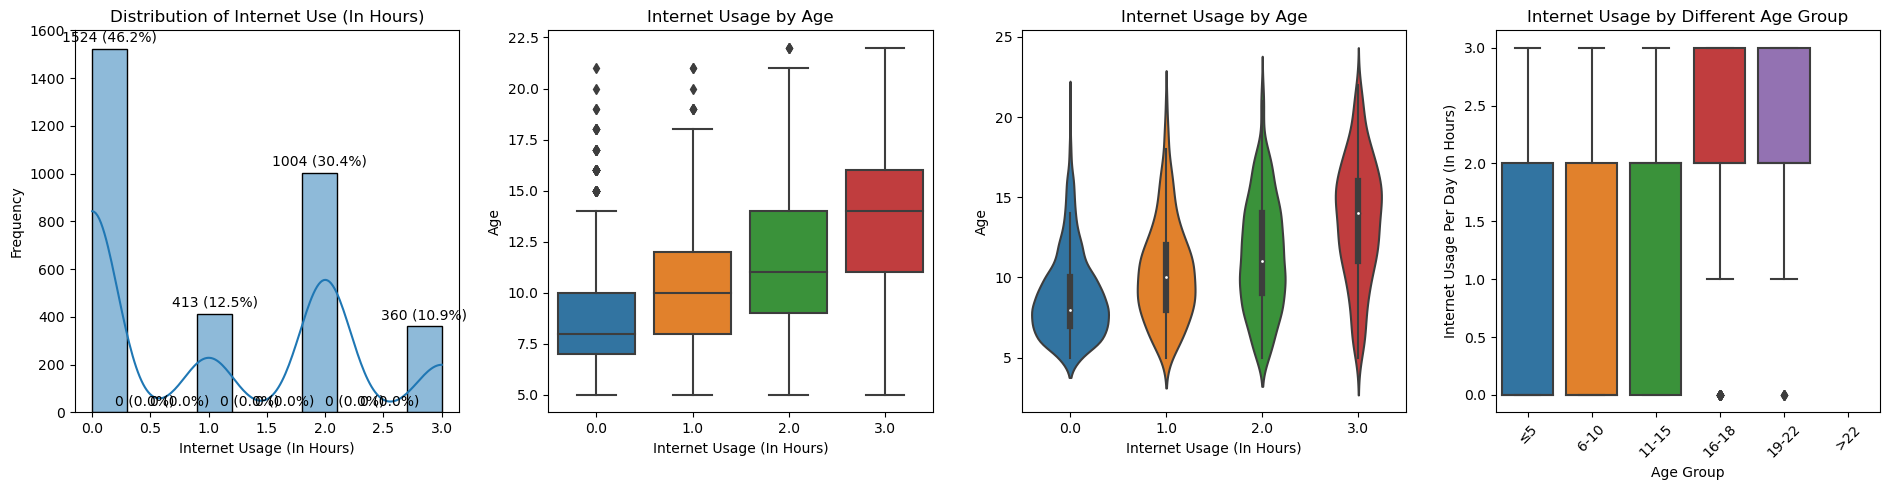

In [67]:
fig, axes = plt.subplots(1, 4, figsize=(19, 5))
ax = axes.ravel()

# Internet usage hours distribution
sns.histplot(data=train_df, x='PreInt_EduHx-computerinternet_hoursday', ax=ax[0], bins=10, kde=True)
ax[0].set_title('Distribution of Internet Use (In Hours)')
ax[0].set_xlabel('Internet Usage (In Hours)')
ax[0].set_ylabel('Frequency')
train_beforeimpute = train_df.copy()
train_internet = train_df.copy()
# Add count and percentage labels to the histogram
total = len(train_internet['PreInt_EduHx-computerinternet_hoursday'].dropna())
for i, p in enumerate(ax[0].patches):
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax[0].annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# Internet usage by Age (boxplot)
sns.boxplot(data=train_df, x='PreInt_EduHx-computerinternet_hoursday', y='Basic_Demos-Age', ax=ax[1])
ax[1].set_title('Internet Usage by Age')
ax[1].set_ylabel('Age')
ax[1].set_xlabel('Internet Usage (In Hours)')

# Internet usage by Age (violin plot)
sns.violinplot(data=train_df, x='PreInt_EduHx-computerinternet_hoursday', y='Basic_Demos-Age', ax=ax[2])
ax[2].set_title('Internet Usage by Age')
ax[2].set_ylabel('Age')
ax[2].set_xlabel('Internet Usage (In Hours)')

# Create age group labels based on the thresholds from your assign_groups function
thresholds = [5, 10, 15, 18, 22]
age_group_labels = [f"≤{thresholds[0]}", 
                    f"{thresholds[0]+1}-{thresholds[1]}", 
                    f"{thresholds[1]+1}-{thresholds[2]}", 
                    f"{thresholds[2]+1}-{thresholds[3]}", 
                    f"{thresholds[3]+1}-{thresholds[4]}", 
                    f">{thresholds[4]}"]

# Map numeric age_group to labels
train_df['age_group_label'] = train_df['age_group'].map(
    {i: label for i, label in enumerate(age_group_labels)}
)

# Internet usage by Age Group (boxplot)
sns.boxplot(data=train_df, x='age_group_label', y='PreInt_EduHx-computerinternet_hoursday', ax=ax[3], 
            order=age_group_labels)
ax[3].set_title('Internet Usage by Different Age Group')
ax[3].set_ylabel('Internet Usage Per Day (In Hours)')
ax[3].set_xlabel('Age Group')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

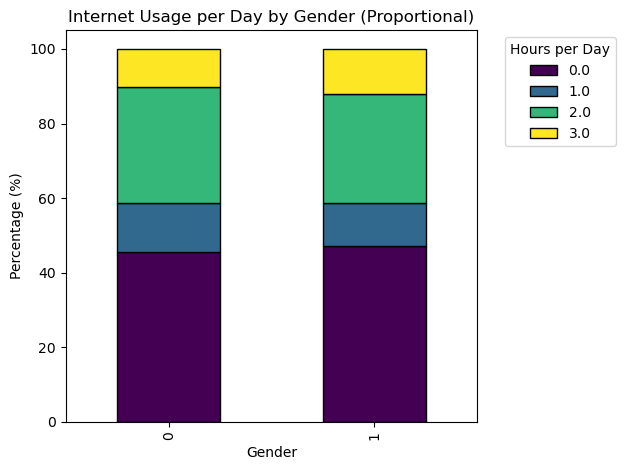

In [68]:
# Recreate proportion stats for plotting
stats_raw = train_df.groupby(['Basic_Demos-Sex', 'PreInt_EduHx-computerinternet_hoursday']).size().unstack(fill_value=0)
stats_prop = stats_raw.div(stats_raw.sum(axis=1), axis=0) * 100

# Plot: Stacked Bar Chart
plt.figure(figsize=(10, 6))
stats_prop.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')

plt.title("Internet Usage per Day by Gender (Proportional)")
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.legend(title="Hours per Day", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [69]:
# SDS-SDS_Total_Raw'
# Define predictor columns (excluding 'Season') and the target variable
internet_hours_impute_features = ['Basic_Demos-Age', 'Basic_Demos-Sex', 'SDS-SDS_Total_Raw']
target_column = 'PreInt_EduHx-computerinternet_hoursday'

# Check for missing values in the features
missing_summary = train_df[internet_hours_impute_features].isna().sum()

# Filter and print only the columns with missing values
missing_columns = missing_summary[missing_summary > 0]
print("Columns with NaN values in training features:")
print(missing_columns)

missing_count = train_df[target_column].isna().sum()
print(f"Missing values in target column '{target_column}': {missing_count}")

# Select rows with known target values for training
training_subset = train_df[train_df[target_column].notna()]
X_train_data = training_subset[internet_hours_impute_features]
y_train_data = training_subset[target_column]

# Define a transformer pipeline for preprocessing
transform_pipeline = ColumnTransformer(
    transformers=[
        ('numeric', 'passthrough', internet_hours_impute_features)
    ]
)

# Combine preprocessing with a logistic regression model
prediction_model = Pipeline(steps=[
    ('transform', transform_pipeline),
    ('logistic_model', LogisticRegression(max_iter=1000, multi_class='ovr'))
])

# Train the model using the available data
prediction_model.fit(X_train_data, y_train_data)


train_missing = train_df[train_df[target_column].isna()][internet_hours_impute_features]
print(train_missing.head())
predicted_values = prediction_model.predict(train_missing)

train_df.loc[train_df[target_column].isna(), target_column] = predicted_values


# Predict and update missing values in the test dataset
test_missing = test_df[test_df[target_column].isna()]
test_df.loc[test_df[target_column].isna(), target_column] = prediction_model.predict(test_missing[internet_hours_impute_features])

Columns with NaN values in training features:
Series([], dtype: int64)
Missing values in target column 'PreInt_EduHx-computerinternet_hoursday': 659
    Basic_Demos-Age  Basic_Demos-Sex  SDS-SDS_Total_Raw
4                18                1          36.666667
9                19                1          40.000000
10               11                1          42.666667
13               12                0          38.000000
29                8                0          37.666667


In [70]:
# Call function to evaluate the updated training data
summarize_data(train_df, [target_column])

,count,mean,std,min,25%,50%,75%,max,missing
PreInt_EduHx-computerinternet_hoursday,3960.0,1.003788,1.083871,0.0,0.0,1.0,2.0,3.0,0


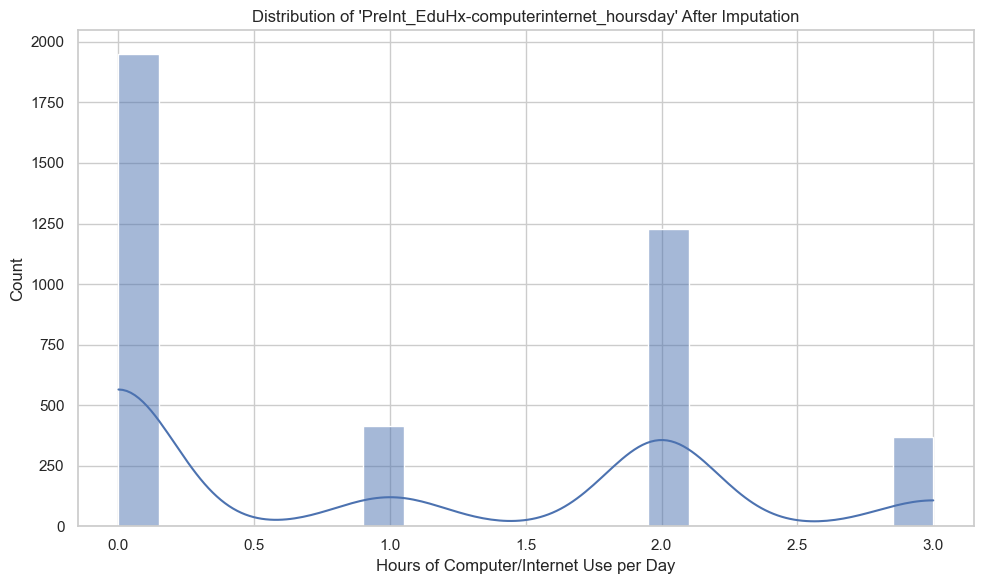

In [71]:
# Set the plot style
sns.set(style="whitegrid")

# Plot the distribution of the target column after imputation
plt.figure(figsize=(10, 6))
sns.histplot(train_df[target_column], bins=20, kde=True)

plt.title(f"Distribution of '{target_column}' After Imputation")
plt.xlabel("Hours of Computer/Internet Use per Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [72]:
# Define the features to normalize
features_to_normalize = ['Basic_Demos-Age', 'PreInt_EduHx-computerinternet_hoursday']

# Initialize the scaler
scaler = MinMaxScaler()

# 1. Fit ONLY on train
scaler.fit(train_df[features_to_normalize])

# 2. Transform train
normalized_features_train = scaler.transform(train_df[features_to_normalize])
train_df['norm_age'] = normalized_features_train[:, 0]
train_df['norm_internet_usage'] = normalized_features_train[:, 1]
train_df['norm_age_internet_product'] = train_df['norm_age'] * train_df['norm_internet_usage']

# 3. Transform test (IMPORTANT: only transform, NOT fit again!)
normalized_features_test = scaler.transform(test_df[features_to_normalize])
test_df['norm_age'] = normalized_features_test[:, 0]
test_df['norm_internet_usage'] = normalized_features_test[:, 1]
test_df['norm_age_internet_product'] = test_df['norm_age'] * test_df['norm_internet_usage']

# 4. Drop unwanted columns (if they exist)
for col in ['norm_age', 'norm_internet_usage', 'age_group_label']:
    if col in train_df.columns:
        train_df = train_df.drop(columns=[col])

    if col in test_df.columns:
        test_df = test_df.drop(columns=[col])

# 5. (Optional) Check stats
print("Train stats after normalization:")
print(train_df[['norm_age_internet_product']].describe())

print("\nTest stats after normalization:")
print(test_df[['norm_age_internet_product']].describe())


Train stats after normalization:
       norm_age_internet_product
count                3960.000000
mean                    0.144499
std                     0.200430
min                     0.000000
25%                     0.000000
50%                     0.000000
75%                     0.274510
max                     1.000000

Test stats after normalization:
       norm_age_internet_product
count                  20.000000
mean                    0.163725
std                     0.174020
min                     0.000000
25%                     0.000000
50%                     0.127451
75%                     0.274510
max                     0.549020


# ACTIGRAPHY

In [73]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(), # Filters out low level noise
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 21) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 6))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [76]:
train_ts = load_time_series("series_train.parquet")


100%|██████████| 996/996 [00:48<00:00, 20.71it/s]


In [77]:
test_ts = load_time_series("series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 13.59it/s]


In [78]:
# Principal Component Analysis
def perform_pca(train, test, n_components=None, random_state=42):
    
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [79]:
# Processing the time series data and merging with the main dataset
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

scaler = StandardScaler() 
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

for c in df_train.columns:
    m = np.mean(df_train[c])
    df_train[c].fillna(m, inplace=True)
    df_test[c].fillna(m, inplace=True)

print(df_train.shape)

df_train_pca, df_test_pca, pca = perform_pca(df_train, df_test, n_components=15, random_state=SEED)

df_train_pca['id'] = train_ts['id']
df_test_pca['id'] = test_ts['id']

train = pd.merge(train_df, df_train_pca, how="left", on='id')
test = pd.merge(test_df, df_test_pca, how="left", on='id')
train.shape

(996, 74)
Explained variance ratio of the components:
 [0.2297803  0.11595334 0.07236788 0.06201337 0.05346817 0.04800129
 0.0408818  0.03782128 0.03380817 0.02967952 0.02575016 0.0241788
 0.02183349 0.02151956 0.01905743]
0.8361145330748827


(3960, 75)

In [80]:
train.to_csv("train_values_merge.csv", index=False)
test.to_csv("test_values_merge.csv", index=False)

In [81]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
categorical_features = ['Basic_Demos-Sex','BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday', 
                        'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 
                        'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 
                        'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 
                        'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 
                        'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 
                        'PCIAT-PCIAT_Total', 'sii', 'id']
features = [f for f in train.columns if f not in exclude]
numerical_features = [f for f in train.columns if f not in categorical_features]
categorical_features_pred = ['Basic_Demos-Sex', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']

In [82]:
train[categorical_features_pred] = train[categorical_features_pred].astype('category')
test[categorical_features_pred] = test[categorical_features_pred].astype('category')

In [83]:
# Identify Categorical & Numerical Columns
categorical_cols = train.select_dtypes(include=['category']).columns
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

print(f"\n📝 Categorical Columns: {list(categorical_cols)}")
print(f"\n🔢 Numerical Columns: {list(numerical_cols)}")


📝 Categorical Columns: ['Basic_Demos-Sex', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday']

🔢 Numerical Columns: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCI

In [84]:
## WE ARE USING LASSO ONLY FOR NUMERICAL FEATURES
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        self.group_means_dict = {} #Stores mean for numerical features and mode for categorical features
        self.group_col = "age_group" # Group column for mean imputation

    '''def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features'''
    
    def find_features(self, data, feature, tmp_features, min_corr=0.4):
        # Step 1: Identify rows where the target feature is missing
        missing_rows = data[feature].isna()

        # Step 2: Exclude tmp_features that are too missing in those rows
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_missingness = np.array(tmp_features)[na_fraction <= self.na_frac]

        # Step 3: Split valid features into numeric and categorical
        numeric_features = [f for f in valid_missingness if pd.api.types.is_numeric_dtype(data[f])]
        categorical_features = [f for f in valid_missingness if not pd.api.types.is_numeric_dtype(data[f])]

        # Step 4: Compute correlation for numeric features only
        if pd.api.types.is_numeric_dtype(data[feature]):
            non_missing_data = data[feature].notna()
            corrs = data.loc[non_missing_data, numeric_features].corrwith(
                data.loc[non_missing_data, feature], numeric_only=True
            )
            valid_numerics = corrs[abs(corrs) >= min_corr].index.tolist()
        else:
            valid_numerics =numeric_features
        # Step 5: Keep numerics with high correlation + all categoricals
        
        valid_features = valid_numerics + categorical_features

        return valid_features



    def fit_models(self, model, data, features, numerical_features):
        self.features = features
        n_data = data.shape[0]
        self.group_means_dict = {}
        for feature in features:
            if pd.api.types.is_float_dtype(data[feature]) or pd.api.types.is_integer_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].mean()
            elif pd.api.types.is_categorical_dtype(data[feature]) or pd.api.types.is_object_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

        for feature in features:
            if data[feature].dtype in ['float64', 'int64']:
                self.mean_dict[feature] = np.mean(data[feature])
            elif data[feature].dtype in ['object', 'category']:
                self.mean_dict[feature] = data[feature].mode().iloc[0]
            
        for feature in tqdm(numerical_features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        group_means = self.group_means_dict[f]
                        X[f] = X.apply(
                            lambda row: group_means[row[self.group_col]] if pd.isna(row[f]) else row[f],
                            axis=1
                        )
                        #X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", self.mean_dict[feature])
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            group_means = self.group_means_dict[feature]
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data
    
    def impute_test(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            if feature in exclude:
                continue
            group_means = self.group_means_dict[feature]
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [85]:
model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, train, features, numerical_features)
train_impute = imputer.impute(train)


100%|██████████| 48/48 [00:05<00:00,  8.95it/s]


In [86]:
## WE ARE USING LASSO ONLY FOR NUMERICAL FEATURES
class Impute_With_Model_lr:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        self.group_means_dict = {} #Stores mean for numerical features and mode for categorical features
        self.group_col = "age_group" # Group column for mean imputation

    '''def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features'''
    
    def find_features(self, data, feature, tmp_features, min_corr=0.4):
        # Step 1: Identify rows where the target feature is missing
        missing_rows = data[feature].isna()

        # Step 2: Exclude tmp_features that are too missing in those rows
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_missingness = np.array(tmp_features)[na_fraction <= self.na_frac]

        # Step 3: Split valid features into numeric and categorical
        numeric_features = [f for f in valid_missingness if pd.api.types.is_numeric_dtype(data[f])]
        categorical_features = [f for f in valid_missingness if not pd.api.types.is_numeric_dtype(data[f])]

        # Step 4: Compute correlation for numeric features only
        if pd.api.types.is_numeric_dtype(data[feature]):
            non_missing_data = data[feature].notna()
            corrs = data.loc[non_missing_data, numeric_features].corrwith(
                data.loc[non_missing_data, feature], numeric_only=True
            )
            valid_numerics = corrs[abs(corrs) >= min_corr].index.tolist()
        else:
            valid_numerics =numeric_features
        # Step 5: Keep numerics with high correlation + all categoricals
        
        valid_features = valid_numerics + categorical_features

        return valid_features



    def fit_models(self, model, data, features, categorical_features):
        self.features = features
        n_data = data.shape[0]
        self.group_means_dict = {}
        for feature in features:
            if pd.api.types.is_float_dtype(data[feature]) or pd.api.types.is_integer_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].mean()
            elif pd.api.types.is_categorical_dtype(data[feature]) or pd.api.types.is_object_dtype(data[feature]):
                self.group_means_dict[feature] = data.groupby(self.group_col)[feature].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

        for feature in features:
            if data[feature].dtype in ['float64', 'int64']:
                self.mean_dict[feature] = np.mean(data[feature])
            elif data[feature].dtype in ['object', 'category']:
                self.mean_dict[feature] = data[feature].mode().iloc[0]
            
        for feature in tqdm(categorical_features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        group_means = self.group_means_dict[f]
                        X[f] = X.apply(
                            lambda row: group_means[row[self.group_col]] if pd.isna(row[f]) else row[f],
                            axis=1
                        )
                        #X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", self.mean_dict[feature])
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            group_means = self.group_means_dict[feature]
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    predicted = model[0].predict(X_missing[model[1]])

                    # If feature is categorical and has categories defined, convert to object before assignment
                    if pd.api.types.is_categorical_dtype(imputed_data[feature]):
                        imputed_data[feature] = imputed_data[feature].astype(object)

                    imputed_data.loc[missing_rows, feature] = predicted
        return imputed_data
    
    def impute_test(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            if feature in exclude:
                continue
            group_means = self.group_means_dict[feature]
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data.loc[missing_rows, feature] = imputed_data.loc[missing_rows].apply(
                        lambda row: group_means.get(row[self.group_col], self.mean_dict[feature]), axis=1
                    )
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    predicted = model[0].predict(X_missing[model[1]])

                    # If feature is categorical and has categories defined, convert to object before assignment
                    if pd.api.types.is_categorical_dtype(imputed_data[feature]):
                        imputed_data[feature] = imputed_data[feature].astype(object)

                    imputed_data.loc[missing_rows, feature] = predicted
        return imputed_data

In [87]:
model_lr = LogisticRegression(max_iter=200, solver='lbfgs', multi_class='auto')
imputer_lr = Impute_With_Model_lr(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer_lr.fit_models(model_lr, train_impute, features, categorical_features_pred)
train_impute_lr = imputer_lr.impute(train_impute)


  0%|          | 0/4 [00:00<?, ?it/s]/Users/kakuly/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|█████     | 2/4 [00:01<00:01,  1.98it/s]/Users/kakuly/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solve

In [88]:
test_impute = imputer.impute_test(test)
test_impute_lr = imputer_lr.impute_test(test_impute)

In [89]:
train_impute_lr.to_csv("train_values_impute.csv", index=False)
test_impute_lr.to_csv("test_values_impute.csv", index=False)

In [3]:
# Loading the datasets
train_file_path = "train_values_impute.csv"
train_df = pd.read_csv(train_file_path)
test_file_path = "test_values_impute.csv"
test_df = pd.read_csv(test_file_path)
df = train_df

In [4]:
train_ft = train_df.copy()
test_ft = test_df.copy()

In [5]:
def create_new_max_min_col(df):
    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1)

    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

In [6]:
create_new_max_min_col(train_ft)

In [7]:
create_new_max_min_col(test_ft)

In [8]:
thresholds = [5, 10, 15, 18, 22]
cu_map = {}
pu_map = {}
tl_map = {}
gs_max_map = {}
gs_min_map = {}
bmr_map = {}
dee_map = {}
sr_min_map = {}
sr_max_map = {}
ffmi_map = {}


prev = 0
for i in range(len(thresholds)):
    curr = thresholds[i]
    mean_cu = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['FGC-FGC_CU'].mean()
    mean_pu = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['FGC-FGC_PU'].mean()
    mean_tl = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['FGC-FGC_TL'].mean()
    mean_gs_max = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['GS_max'].mean()
    mean_gs_min = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['GS_min'].mean()
    mean_bmr = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['BIA-BIA_BMR'].mean()
    mean_dee = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['BIA-BIA_DEE'].mean()
    mean_sr_min = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['SR_min'].mean()
    mean_sr_max = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['SR_max'].mean()
    mean_ffmi = train_ft[(train_ft['Basic_Demos-Age'] > prev) & (train_ft['Basic_Demos-Age'] <= curr)]['BIA-BIA_FFMI'].mean()
    cu_map[i] = mean_cu
    pu_map[i] = mean_pu
    tl_map[i] = mean_tl
    gs_max_map[i] = mean_gs_max
    gs_min_map[i] = mean_gs_min
    bmr_map[i] = mean_bmr
    dee_map[i] = mean_dee
    sr_min_map[i] = mean_sr_min
    sr_max_map[i] = mean_sr_max
    ffmi_map[i] = mean_ffmi
    
    prev = curr

In [9]:
print("cu_map: ", cu_map)
print("pu_map: ", pu_map)
print("tl_map: ", tl_map)
print("gs_max_map", gs_max_map)
print("gs_min_map", gs_min_map)
print("bmr_map", bmr_map)
print("dee_map", dee_map)
print("sr_min_map", sr_min_map)
print("sr_max_map", sr_max_map)
print("ffmi_map", ffmi_map)

cu_map:  {0: 1.4894075826009996, 1: 7.476433412668704, 2: 16.73709242262834, 3: 21.407771986194827, 4: 25.30853654685808}
pu_map:  {0: 1.6124985934130887, 1: 4.5169419747697965, 2: 6.784395686334561, 3: 8.478444895075162, 4: 6.821968965779475}
tl_map:  {0: 8.120492018715137, 1: 8.869554898368646, 2: 9.838626506051705, 3: 9.917901720651995, 4: 9.692428580093807}
gs_max_map {0: 3.9099297688947945, 1: 10.55672195840937, 2: 23.292464861164753, 3: 32.78846762533555, 4: 38.36685722870873}
gs_min_map {0: 2.736800716173679, 1: 10.002960767347604, 2: 21.30362495880886, 3: 29.72703462536007, 4: 35.603563385045724}
bmr_map {0: 923.5225434249359, 1: 1044.0911206823437, 2: 1349.4340136900846, 3: 1570.3551673344439, 4: 1600.771724721695}
dee_map {0: 1482.2122961876526, 1: 1727.4929346670194, 2: 2287.120935391911, 3: 2659.7318780880137, 4: 2689.29223414726}
sr_min_map {0: 9.096963629930148, 1: 8.625937676320195, 2: 8.155678517119915, 3: 8.436815249729667, 4: 8.8197600575827}
sr_max_map {0: 9.87557177

In [10]:
def bin_data(train, test, columns, n_bins=10):
    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)

    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges correctly
        edges = pd.qcut(combined[col], n_bins, retbins=True, labels=False, duplicates="drop")[1]
        bin_edges[col] = edges

    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        num_bins = len(edges) - 1  # Ensure the correct number of labels
        labels = range(num_bins)   # Matching labels with bins

        train[col] = pd.cut(train[col], bins=edges, labels=labels, include_lowest=True).astype(float)
        test[col] = pd.cut(test[col], bins=edges, labels=labels, include_lowest=True).astype(float)

    return train, test

In [11]:
def feature_engineering(df):

    df["CU_norm"] = df['FGC-FGC_CU'] / df['age_group'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['age_group'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['age_group'].map(tl_map)

    df['GS_max_norm'] = df['GS_max'] / df["age_group"].map(gs_max_map)
    df['GS_min_norm'] = df['GS_min'] / df["age_group"].map(gs_min_map)

    df['SR_max_norm'] = df['SR_max'] / df["age_group"].map(gs_max_map)
    df['SR_min_norm'] = df['SR_min'] / df["age_group"].map(gs_min_map)

    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["age_group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["age_group"].map(dee_map)

    df["FFMI_norm"] = df["BIA-BIA_FFMI"] / df["age_group"].map(ffmi_map)

    df["ECW_ICW_ratio"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]

In [12]:
columns_to_bin = [
    "CU_norm", "PU_norm", "TL_norm", "GS_min_norm", "GS_max_norm", 
    "SR_min_norm", "SR_max_norm", "BMR_norm", "DEE_norm", "FFMI_norm", "Physical-HeartRate", "Physical-Waist_Circumference", "Physical-Height" ,"Physical-Weight"
]

In [13]:
# 'BIA-BIA_BMI' already removed, so no need to add here
columns_to_remove = ['FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 
                    'BIA-BIA_FFM', 'BIA-BIA_FMI','BIA-BIA_Frame_num', 'BIA-BIA_LDM']

In [14]:
feature_engineering(train_ft)

In [15]:
feature_engineering(test_ft)

In [16]:
train_ft, test_ft = bin_data(train_ft, test_ft, columns_to_bin, n_bins=10)

In [17]:
train_ft = train_ft.drop(columns_to_remove, axis=1)

In [18]:
test_ft = test_ft.drop(columns_to_remove, axis=1)

In [19]:
train_ft.shape

(3960, 79)

In [20]:
train_ft.to_csv("train_ft.csv", index=False)
test_ft.to_csv("test_ft.csv", index=False)

In [21]:
# Loading the datasets
train_file_path = "train_ft.csv"
train = pd.read_csv(train_file_path)
test_file_path = "test_ft.csv"
test = pd.read_csv(test_file_path)
df = train

In [22]:
train.dropna(subset=['sii'], how='all', inplace=True)


In [23]:
sii_thresholds = [30, 50, 80, 100] # Thresholds for rating
def get_rating(x): ## Thresholds for rating
    if 0 <= x <= 29:
        return 0
    elif 30 <= x <= 49:
        return 1
    elif 50 <= x <= 79:
        return 2
    else:
        return 3

def quadratic_weighted_kappa(y_true, y_pred): # The Quadric Kappa Evaluation Metric
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def evaluate_predictions(y_true, oof_non_rounded):
    rounded_p = get_rating(oof_non_rounded)
    return -quadratic_weighted_kappa(y_true, rounded_p)

#train_impute_lr['new_sii'] = train_impute_lr['PCIAT_Total_Imputed'].apply(get_rating)

In [24]:
for col in train.columns:
    if train[col].dtype == 'object' or str(train[col].dtype) == 'category':
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col].astype(str))

for col in test.columns:
    if test[col].dtype == 'object' or str(test[col].dtype) == 'category':
        le = LabelEncoder()
        test[col] = le.fit_transform(test[col].astype(str))



In [25]:
train_model = train
Y_target = train['PCIAT-PCIAT_Total']
X = train_model.drop(columns=['id', 'sii', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03','PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total'])
Y_class = train['sii']

In [26]:
## BALANCING THE DATASET (UPSAMPLING AND DOWNSAMPLING IS NOT APPROPRIATE FOR THIS DATASET)
def sample_weights_optimized(series):
    """
    Calculate sample weights for continuous PCIAT target variables using equal-width binning to solve class imbalance issue by finding frequency of each pciat total value: Converts frequency into weight:
    Rare bins get higher weights (inverse of frequency is used to calculate weight )
    Common bins get lower weights
  
    
    Parameters:
    series: pandas Series containing all target values (assumed continuous with no nulls)
    
    Returns:
    pandas Series: Sample weights normalized to mean 1.0
    """
    # Handle edge cases efficiently
    if len(series) <= 1 or series.nunique() <= 1:
        return pd.Series(1.0, index=series.index)
    
    # Create equal-width bins directly
    bins = pd.cut(series, bins=10, labels=False)
    
    # Get bin counts and calculate inverse frequency in one step
    bin_counts = bins.value_counts()
    inverse_freq = 1.0 / bin_counts
    
    # Map weights back to samples using the bin indices
    weights = bins.map(inverse_freq)
    
    # Normalize weights to mean 1.0
    return weights / weights.mean()

In [27]:
def convert_to_categories(predictions, boundary_values):
    """
    Transform continuous prediction values into discrete categories 
    based on specified boundary thresholds.
    """
    categories = np.zeros(len(predictions), dtype=int)
    
    # Apply each threshold sequentially
    for category, threshold in enumerate(boundary_values):
        categories[predictions >= threshold] = category + 1
        
    return categories


def find_optimal_boundaries(actual_values, model_predictions, initial_boundaries=None):
    """
    Determine the optimal category boundaries that maximize agreement
    between predictions and actual values using quadratic weighted kappa.
    """
    # Set default initial boundaries if none provided
    if initial_boundaries is None:
        initial_boundaries = [0.5, 1.5, 2.5]
    
    # Define optimization objective function
    def objective_function(boundaries, actuals, predictions):
        categorized_predictions = convert_to_categories(predictions, boundaries)
        kappa_score = cohen_kappa_score(actuals, categorized_predictions, weights='quadratic')
        # Return negative since we want to maximize kappa
        return -kappa_score
    
    # Perform optimization
    optimization_result = minimize(
        objective_function, 
        x0=initial_boundaries,
        args=(actual_values, model_predictions),
        method='Powell'
    )
    
    # Verify optimization completed successfully
    if not optimization_result.success:
        raise RuntimeError("Boundary optimization failed to converge")
        
    return optimization_result.x

In [28]:
def evaluate_k_fold_validate(estimator, dataset, target_col, class_col, splitter, apply_weighting=False, show_progress=False):
   """
   Evaluates a model using k-fold validation, optimizing decision boundaries to maximize agreement.
   
   Parameters:
   - estimator: Model object with fit and predict methods
   - dataset: DataFrame containing all data
   - predictors: List of feature column names
   - target_col: Column name for continuous target variable
   - class_col: Column name for class labels
   - splitter: Cross-validation iterator
   - apply_weighting: Whether to apply balancing weights during training
   - show_progress: Whether to display progress information
   
   Returns:
   - mean_agreement: Average kappa agreement score across folds
   - holdout_predictions: Predictions for all samples from their respective holdout folds
   - boundary_sets: Optimized decision boundaries from each fold
   """
   agreement_metrics = []
   holdout_predictions = np.zeros(dataset.shape[0])
   boundary_sets = []
   
   # Default decision boundaries if needed
   default_boundaries = sii_thresholds
   
   # Iterate through cross-validation folds
   for fold_num, (training_indices, validation_indices) in enumerate(splitter.split(dataset, class_col)):
       # Extract training and validation data
       X_training = dataset.iloc[training_indices]
       y_training_target = target_col.iloc[training_indices] ## PCIAT Total
       y_training_class = class_col.iloc[training_indices] ## SII
       
       X_validation = dataset.iloc[validation_indices]
       y_validation_target = target_col.iloc[validation_indices]  ## PCIAT Total
       y_validation_class = class_col.iloc[validation_indices] ## SIIs

       # # Remove the 'id' column from your training data
       # X_training = X_training.drop(columns=['id'])
       # X_validation = X_validation.drop(columns=['id'])
       
       # Apply sample weighting if needed for class imbalance issue 
       if apply_weighting:
           sample_weights = sample_weights_optimized(y_training_target)
           estimator.fit(X_training, y_training_target, sample_weight=sample_weights)
       else:
           estimator.fit(X_training, y_training_target)
       
       # Generate predictions
       training_predictions = estimator.predict(X_training)
       validation_predictions = estimator.predict(X_validation)
       
       # Store predictions in the appropriate positions
       holdout_predictions[validation_indices] = validation_predictions
       
       # Optimize decision boundaries based on training predictions
       optimized_boundaries = find_optimal_boundaries(
           y_training_class, 
           training_predictions, 
           initial_boundaries=default_boundaries
       )
       boundary_sets.append(optimized_boundaries)
       
       # Apply optimized boundaries to validation predictions
       discretized_predictions = convert_to_categories(validation_predictions, optimized_boundaries)
       
       # Calculate kappa metric
       kappa = cohen_kappa_score(y_validation_class, discretized_predictions, weights='quadratic')
       agreement_metrics.append(kappa)
       # 
       if show_progress:
           print(f"Fold {fold_num+1}: Quadratic Kappa = {kappa:.4f}")
   
   if show_progress:
       print(f"Mean Agreement: {np.mean(agreement_metrics):.4f}")
       print(f"Standard Deviation: {np.std(agreement_metrics):.4f}")
   
   return np.mean(agreement_metrics), holdout_predictions, boundary_sets

In [29]:
def objective(trial, dataset, target_col, class_col, splitter, apply_weighting):
    params = {
        'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:tweedie']),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 0.1),
        'random_state': 42,
        'verbosity': 0
    }

    if params['objective'] == 'reg:tweedie':
        params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1.0, 2.0)

    model = XGBRegressor(**params)
    score, _, _ = evaluate_k_fold_validate(
        estimator=model,
        dataset=dataset,
        target_col=target_col,
        class_col=class_col,
        splitter=splitter,
        apply_weighting=apply_weighting,
        show_progress=False
    )
    return score

In [30]:
def run_optuna_tuning(dataset, target_col, class_col, splitter, apply_weighting=True, n_trials=30):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, dataset, target_col, class_col, splitter, apply_weighting),
                   n_trials=n_trials)

    print("\nBest Parameters:")
    print(study.best_params)
    print(f"Best Quadratic Kappa: {study.best_value:.4f}")
    return study.best_params


In [32]:
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
best_params =  run_optuna_tuning(X, Y_target, Y_class, splitter, apply_weighting=True, n_trials=30)

[I 2025-04-17 20:18:54,229] A new study created in memory with name: no-name-a1737a58-ad06-489d-b677-eac51b49726d
[I 2025-04-17 20:18:57,876] Trial 0 finished with value: 0.4394628953922631 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 117, 'max_depth': 4, 'learning_rate': 0.05566836865397702, 'subsample': 0.5471803204414752, 'colsample_bytree': 0.5546946369379318, 'reg_alpha': 0.05620022191158625, 'reg_lambda': 0.08604647912630235}. Best is trial 0 with value: 0.4394628953922631.
[I 2025-04-17 20:19:01,644] Trial 1 finished with value: 0.4439002993252991 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.037084376923656306, 'subsample': 0.780463175918342, 'colsample_bytree': 0.6330206098729104, 'reg_alpha': 0.05459094376027763, 'reg_lambda': 0.05823372746348433}. Best is trial 1 with value: 0.4439002993252991.
[I 2025-04-17 20:19:07,498] Trial 2 finished with value: 0.426008175469245 and parameters: {'objective


Best Parameters:
{'objective': 'reg:tweedie', 'n_estimators': 103, 'max_depth': 2, 'learning_rate': 0.09380091603133955, 'subsample': 0.7403858273113502, 'colsample_bytree': 0.6800089253325196, 'reg_alpha': 0.06915747269156809, 'reg_lambda': 0.07106972796739008, 'tweedie_variance_power': 1.3721985586784886}
Best Quadratic Kappa: 0.4493


In [34]:
xgb_model = XGBRegressor(**best_params, random_state=42)

In [35]:
weights = sample_weights_optimized(train['PCIAT-PCIAT_Total'])
score_xgb, holdout_predictions, xgb_thresholds_otm = evaluate_k_fold_validate(xgb_model, X, Y_target, Y_class, splitter, apply_weighting=True)

In [36]:
xgb_model.fit(X, Y_target, sample_weight=weights)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6800089253325196, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09380091603133955,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=103, n_jobs=None,
             num_parallel_tree=None, ...)

In [37]:
xgb_thresholds_ens = np.mean(xgb_thresholds_otm, axis=0)

In [38]:
test = test.drop(columns=['id', 'BIA-BIA_BMI', 'SDS-SDS_Total_T'])

In [39]:
predictions_xgb = xgb_model.predict(test)
# Apply the optimized thresholds to convert continuous predictions to discrete categories
test_lgb = convert_to_categories(predictions_xgb, xgb_thresholds_ens)

# Create submission file
submission = pd.read_csv("submission.csv")
submission['sii'] = test_lgb
submission.to_csv("submission.csv", index=False)